# UKdrivers

注意：こちらは応用編です。最初に [8school.ipynb](8school.ipynb)をご覧ください。

StunでUKdriversデータを扱うのに関しては、こちらの[Rstanでの記事](https://github.com/sinhrks/stan-statespace)を参考にしました。

## データの入手方法

状態空間モデルの例として、
["An Introduction to State Space Time Series Analysis" サポートページ](http://www.ssfpack.com/CKbook.html)から、
ファイル [http://staff.feweb.vu.nl/koopman/projects/ckbook/OxCodeAll.zip](http://staff.feweb.vu.nl/koopman/projects/ckbook/OxCodeAll.zip) をダウンロードして解凍します。
解凍して得られるフォルダの `Chapter_7` ディレクトリ下にある `UKdriversKSI.txt`, `logUKpetroprice.txt`を、このjupyter notebookのあるディレクトリにコピーします。(データの入手は各自で行ってください。このリポジトリには含まれていません)

なお、この教科書は「状態空間時系列分析入門」という邦題で翻訳書が発売されています。状態空間モデルを用いた時系列分析に関するお勧めの教科書です。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import statsmodels.api as sm
import pystan

## データの説明

`UKdriversKSI.txt` は "monthly UK drivers KSI 1969-1984" つまり 1969-1984 年の月次の英国ドライバーの死傷者数のデータ$\{y_t\}$です。今回の目的はこれを解析することです。

`logUKpetroprice.txt` は "monthly UK log(petrol price) 1969-1984" であり、同じ期間の石油価格の対数です。死傷者数の説明変数に石油価格$\{x_t\}$を追加します。

In [2]:
df_driver = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None, names=['v'])
df_petrol = pd.read_table('logUKpetrolprice.txt', skiprows=1, header=None, names=['v'])

また、英国では 1983/2 からシートベルト法が施行されたため、1983/2 ($t=169$) 以後は法律の影響があるはずです。これも後ほど、説明変数に$\{w_t\}$として取り込みます。 

シートベルト法制化前を$0$、法制化後を$1$として、法制化の効果を考えることにします。

In [3]:
seats=np.concatenate((np.zeros((1982-1968)*12+1), np.ones((1984 - 1982)*12-1)))

死傷者数は対数変換したほうが適切と考えるので対数変換します。

簡単にグラフを書いてみます。
* 死傷者数の増減 (赤線のタイミングで法改正)
* 石油価格の増減
* X=石油価格、Y=死傷者数、の散布図

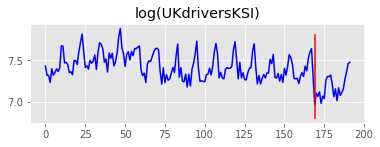

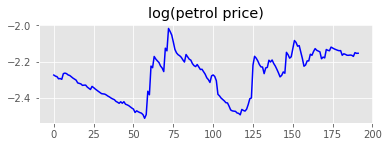

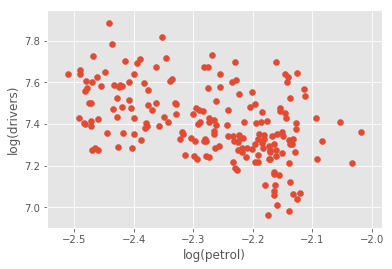

In [4]:
xps = np.linspace(0,191,192) # x座標
rawdrivers = [float(v) for v in df_driver['v'].values] # 生の死傷者数
drivers = [np.log(v) for v in rawdrivers] # 対数変換した死傷者数
petrols = [float(v) for v in df_petrol['v'].values] # 対数変換した石油価格

plt.subplot(2,1,1)
plt.plot(xps, drivers, "b")
plt.plot([169,169], [6.8, 7.8], "r")
plt.title('log(UKdriversKSI)')
plt.show()
plt.subplot(2,1,2)
plt.plot(xps, petrols, "b")
plt.title('log(petrol price)')
plt.show()
plt.scatter(petrols, drivers)
plt.xlabel('log(petrol)')
plt.ylabel('log(drivers)')
plt.show()

グラフをみて解ることは
* 法改正で死傷者数が減っている
* 石油価格と死傷者数には負の相関がありそう
* 12ヶ月周期の変動が見える

12ヶ月周期があることを確認するため、自己相関係数をみます。

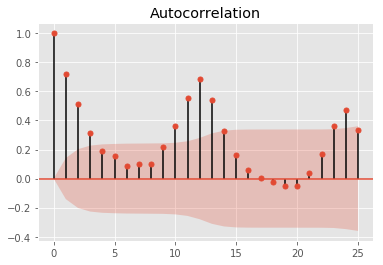

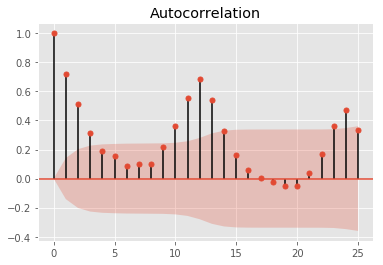

In [5]:
sm.graphics.tsa.plot_acf(drivers, lags=25)

## 単なる線形モデル

状態空間モデルの前に、単なる線形モデルで解析してみます。

$$\begin{eqnarray}
x_t &=& \log(\text{石油価格}) \\
w_t &=& 0 \text{(法改正前) あるいは} 1 \text{(法改正後)} \\
y_t &=& \log(\text{死傷者数}) \sim \mathcal{N}(\mu + \beta x_t + \lambda w_t + s_t, \; \sigma_{\mathrm{obs}})
\end{eqnarray}$$
ただしパラメータは、下記のようなものです。
$$\begin{eqnarray}
\mu &=& \log(\text{死傷者数})\text{の平均} \\
\beta &=& x_t \text{の重み} \\
\lambda &=& w_t \text{の重み} \\
s_t &=& \text{季節変動項}, \;\; \sum_{t=i}^{i+11}s_t = 0
\end{eqnarray}$$


モデルを表現します。

季節項の独立なパラメータは $s_t \; (t=0\sim 10)$ の11個だけで、$t \geq 11$ に関しては
$$s_t = -\sum_{i=t-11}^{t-1} s_i$$
で求められることに注意してください。

In [6]:
model_code = """
data {
  int<lower=1> N;
  vector[N] Y; # driver
  vector[N] X; # petrol
  vector[N] W; # seatbelt
}
parameters {
  real mu; # level
  vector[11] seas; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_obs; # obs. error
}
transformed parameters {
  vector[N] s;
  for(t in 1:11) {
    s[t] = seas[t];
  }
  for(t in 12:N) {
    s[t] = -s[t-11]-s[t-10]-s[t-9]-s[t-8]-s[t-7]-s[t-6]-s[t-5]-s[t-4]-s[t-3]-s[t-2]-s[t-1];
  }
}
model {
  for(t in 1:N) {
    Y[t] ~ normal(mu + beta*X[t] + lambda*W[t] + s[t], sigma_obs);
  }
}
"""

与えるデータは下記の通りになります。

In [7]:
data = {'N': 192, 'Y': drivers, 'X': petrols, 'W': seats }

stanを実行します。興味のある方は各自`iter`などを調整してみてもよいでしょう。

In [8]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74c25e5b22d890d1ee5658705d59944c NOW.


CPU times: user 1.07 s, sys: 144 ms, total: 1.21 s
Wall time: 28.7 s


In [9]:
print(fit)

Inference for Stan model: anon_model_74c25e5b22d890d1ee5658705d59944c.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           6.4  3.6e-3   0.13   6.15   6.31    6.4   6.49   6.65   1230   1.01
seas[0]   7.0e-3  4.7e-4   0.02  -0.03-7.9e-3 6.9e-3   0.02   0.05   2000    1.0
seas[1]    -0.11  4.7e-4   0.02  -0.15  -0.12  -0.11  -0.09  -0.06   2000    1.0
seas[2]    -0.07  4.7e-4   0.02  -0.11  -0.08  -0.07  -0.05  -0.03   2000    1.0
seas[3]    -0.14  4.7e-4   0.02  -0.18  -0.16  -0.14  -0.13   -0.1   2000    1.0
seas[4]    -0.05  4.6e-4   0.02   -0.1  -0.07  -0.05  -0.04  -0.01   2000    1.0
seas[5]    -0.09  4.7e-4   0.02  -0.13   -0.1  -0.09  -0.07  -0.05   2000    1.0
seas[6]    -0.04  4.5e-4   0.02  -0.08  -0.05  -0.04  -0.02 2.4e-3   2000    1.0
seas[7]    -0.03  4.6e-4   0.02  -0.07  -0.04  -0.03  -0.02   0.01   2000    1.0
sea

スカラー値とベクトル値の平均値を求める関数を定義

In [10]:
def ave_s(la, vname):
    return np.average(la[vname])
def ave_v(la, vname):
    n = len(la[vname])
    acc = np.zeros(192)
    for i in range(0, n):
        acc = acc + la[vname][i]
    return (acc/n)

fitから値を取り出す関数を定義

In [11]:
def calc_term_lin(fit):
    la = fit.extract(permuted=True)
    term_mu = np.ones(192)*ave_s(la, 'mu') # 平均値 mu
    term_beta = np.array(petrols)*ave_s(la, 'beta') # 石油の影響
    term_lambda = seats*ave_s(la, 'lambda') # 法改正の影響 
    term_seasonal = ave_v(la, 's')
    term_res = drivers-(term_mu+term_lambda+term_beta+term_seasonal)
    print("mu={0}\nbeta={1}\nlambda={2}".format(ave_s(la, 'mu'), ave_s(la, 'beta'), ave_s(la, 'lambda')))
    print("sigma_obs={0}".format(ave_s(la, 'sigma_obs')))
    return (term_mu, term_beta, term_lambda, term_seasonal, term_res)

グラフをプロットする関数を定義

In [12]:
def do_plot(terms):
    term_mu, term_beta, term_lambda, term_seasonal, term_res = terms

    plt.figure(figsize=(6, 4))
    plt.plot(xps, term_mu+term_lambda+term_beta, "g", label='without seasonal')
    plt.plot(xps, term_mu+term_lambda+term_beta+term_seasonal, "r", label='with seasonal')
    plt.plot(xps, drivers, "b", label='real data')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(xps, term_mu+term_lambda+term_beta, "r", label='fit without seasonal')
    plt.plot(xps, drivers-term_seasonal, "b", label='real data without seasonal')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 10))
    plt.subplot(5,1,1)
    plt.plot(xps, term_mu, "b", label='$\mu_t$')
    plt.title('mu_t')
    plt.subplot(5,1,2)
    plt.plot(xps, term_lambda, "b", label='$\lambda w_t$')
    plt.title('lambda w_t')
    plt.subplot(5,1,3)
    plt.plot(xps, term_beta, "b", label='$\beta x_t$')
    plt.title('beta x_t')
    plt.subplot(5,1,4)
    plt.plot(xps, term_seasonal, "b", label='seasonal')
    plt.title('s_t')
    plt.subplot(5,1,5)
    plt.plot(xps, term_res, "b", label='residue')
    plt.title('residual')
    plt.show()
    sm.graphics.tsa.plot_acf(drivers-(term_mu+term_lambda+term_beta+term_seasonal), lags=25)

結果を表示します

残差にはなめらかな変化が残っているように見えます。それは自己相関をプロットしてみてもわかります。平均値が一定であるという仮定に無理がありそうです。

mu=6.399567162066813
beta=-0.45298276189453596
lambda=-0.196570389916958
sigma_obs=0.0865180121301257


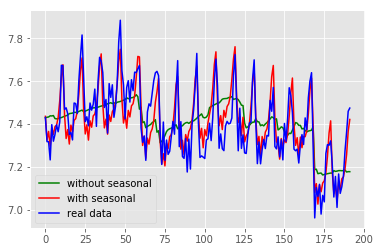

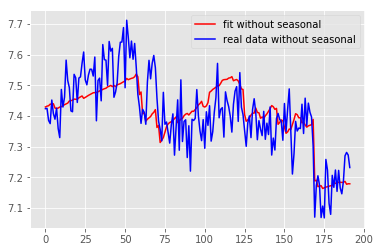

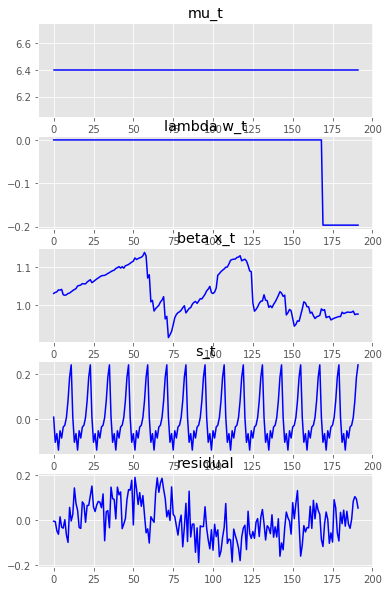

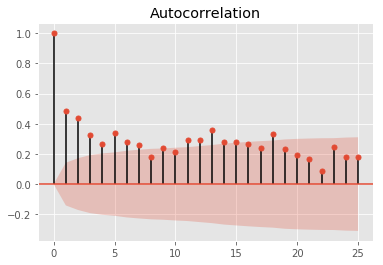

In [13]:
do_plot(calc_term_lin(fit))

## 状態空間モデル

平均値 $\mu$ は不変ではなく、ほぼ直前の値 $x_{t-1}$ と等しいが揺らぎ $\sigma_\mu$ を持っている、という仮定を入れます。$y_t$ は真の値 $\mu_t$ に測定誤差 $\sigma_{\text{obs}}$ を含んだものとして観測されます。
このようなモデルを状態空間モデル（一階のトレンドモデル）と呼びます。

さらに季節項にも変動 $\sigma_s$ を許します。

$$\begin{eqnarray}
\mu_t & \sim & \mathcal{N}(\mu_{t-1}, \sigma_\mu) \\
s_t & \sim & \mathcal{N}(-\sum_{i=1}^{11}s_{t-i}, \; \sigma_s) \\
y_t & \sim & \mathcal{N}(\mu_t + \beta x_t + \lambda w_t + s_t, \; \sigma_{\mathrm{obs}})
\end{eqnarray}$$

今回はMCMC収束の都合上、 $\sigma_\mu, \; \sigma_s, \; \sigma_{\text{obs}}$ については事前分布を与えています。
また、$\mu_t$ についても $y_t$ の値から上限下限を定めています。

In [14]:
model_code = """
data {
  int<lower=1> N;
  vector[N] Y; # driver
  vector[N] X; # petrol
  vector[N] W; # seatbelt
}
parameters {
  vector<lower=mean(Y)-3*sd(Y), upper=mean(Y)+3*sd(Y)>[N] mu;
  vector[N] s; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_mu; # mu error
  real<lower=0> sigma_s; # seas error
  real<lower=0> sigma_obs; # obs. error
}
model {
  for(t in 12:N) {
    s[t] ~ normal(-s[t-11]-s[t-10]-s[t-9]-s[t-8]-s[t-7]-s[t-6]-s[t-5]-s[t-4]-s[t-3]-s[t-2]-s[t-1], sigma_s);
  }
  for(t in 2:N)
    mu[t] ~ normal(mu[t-1], sigma_mu);
  for(t in 1:N)
    Y[t] ~ normal(mu[t] + beta*X[t] + lambda*W[t] + s[t], sigma_obs);

  sigma_mu ~ inv_gamma(0.001, 0.001);
  sigma_s ~ inv_gamma(0.001, 0.001);
  sigma_obs ~ inv_gamma(0.001, 0.001);}
"""

In [15]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b216818153cf7898de6bc2a0d7c6ccc NOW.


CPU times: user 1.21 s, sys: 138 ms, total: 1.35 s
Wall time: 3min 4s


In [16]:
print(fit)

Inference for Stan model: anon_model_7b216818153cf7898de6bc2a0d7c6ccc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        7.1    0.03   0.12   6.95   7.01   7.06   7.14   7.44     14   1.18
mu[1]        7.1    0.03   0.12   6.96   7.01   7.06   7.15   7.45     14   1.18
mu[2]       7.09    0.03   0.12   6.96   7.01   7.06   7.14   7.44     14   1.18
mu[3]        7.1    0.03   0.12   6.96   7.01   7.06   7.15   7.44     15   1.18
mu[4]        7.1    0.03   0.12   6.96   7.02   7.06   7.15   7.44     14   1.18
mu[5]        7.1    0.03   0.12   6.96   7.02   7.06   7.15   7.44     15   1.18
mu[6]        7.1    0.03   0.12   6.96   7.02   7.06   7.15   7.44     14   1.19
mu[7]        7.1    0.03   0.12   6.97   7.02   7.07   7.15   7.45     15   1.19
mu[8]        7.1    0.03   0.12   6.97   7.02   7.07   7.15   7.44     15   1.19
m

Rhatの値が悪いと思う場合は、MCMCの条件を色々変えてみてください。

結果の取り出しと表示を行います。
* $\sigma_\mu < \sigma_{\text{obs}}$ と期待する結果(測定の誤差は大きいが真の値の揺らぎは小さいという仮定)にあった結果が得られた。
* 2番目のグラフを見るとわかりやすいが、変動のトレンドを綺麗に捉えているように見える。
* 自己相関も消えている
* ただし、$\mu_t$ の変化には滑らかさが少ない。

beta=-0.13827977502174685
lambda=-0.23833662583271506
sigma_mu=0.01915567877237199
sigma_s=0.0032916157508936952
sigma_obs=0.06194879039297064


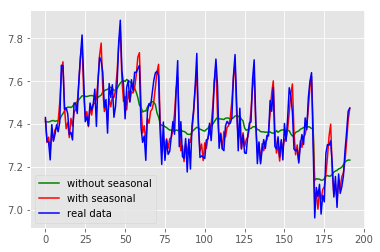

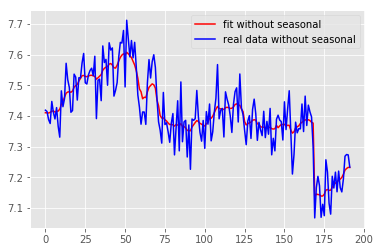

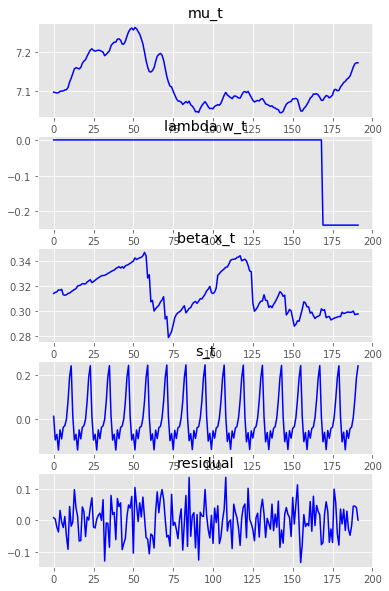

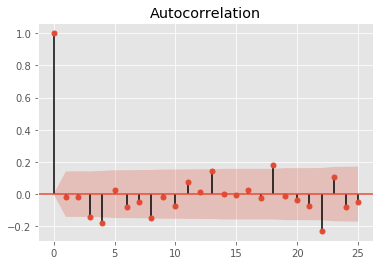

In [17]:
def calc_term_trend(fit):
    la = fit.extract(permuted=True)
    term_mu = ave_v(la,'mu') # 平均値 mu
    term_beta = np.array(petrols)*ave_s(la,'beta') # 石油の影響
    term_lambda = seats*ave_s(la,'lambda') # 法改正の影響 
    term_seasonal = ave_v(la,'s')
    term_res = drivers-(term_mu+term_lambda+term_beta+term_seasonal)
    print("beta={0}\nlambda={1}".format(ave_s(la, 'beta'), ave_s(la, 'lambda')))
    print("sigma_mu={0}\nsigma_s={1}\nsigma_obs={2}".format( \
        ave_s(la, 'sigma_mu'), ave_s(la, 'sigma_s'), ave_s(la, 'sigma_obs')))
    return (term_mu, term_beta, term_lambda, term_seasonal, term_res)

do_plot(calc_term_trend(fit))

### 2階のトレンドモデル

$\mu_t$ の滑らかな変化を得るために、値の連続性ではなく傾きの連続性を条件に入れます。つまり
$$\mu_t - \mu_{t-1} = \mu_{t-1} - \mu_{t-2} + \epsilon_t$$
より
$$\mu_t \sim \mathcal{N}(2\mu_{t-1} - \mu_{t-2}, \sigma_\mu)$$
と変更します。

In [18]:
model_code = """
data {
  int<lower=1> N;
  vector[N] Y; # driver
  vector[N] X; # petrol
  vector[N] W; # seatbelt
}
parameters {
  vector<lower=mean(Y)-3*sd(Y), upper=mean(Y)+3*sd(Y)>[N] mu;
  vector[N] s; # seasonal term
  real beta; # reg. param
  real lambda; # coeff.
  real<lower=0> sigma_mu; # mu error
  real<lower=0> sigma_s; # seas error
  real<lower=0> sigma_obs; # obs. error
}
model {
  for(t in 12:N) {
    s[t] ~ normal(-s[t-11]-s[t-10]-s[t-9]-s[t-8]-s[t-7]-s[t-6]-s[t-5]-s[t-4]-s[t-3]-s[t-2]-s[t-1], sigma_s);
  }
  for(t in 3:N)
    mu[t] ~ normal(2*mu[t-1]-mu[t-2], sigma_mu);
  for(t in 1:N)
    Y[t] ~ normal(mu[t] + beta*X[t] + lambda*W[t] + s[t], sigma_obs);

  sigma_mu ~ inv_gamma(0.001, 0.001);
  sigma_s ~ inv_gamma(0.001, 0.001);
  sigma_obs ~ inv_gamma(0.001, 0.001);}
"""

In [19]:
%time fit = pystan.stan(model_code=model_code, data=data, iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3dc05ea799cb2e56aad31172b419865e NOW.


CPU times: user 1.3 s, sys: 150 ms, total: 1.45 s
Wall time: 3min 30s


In [20]:
print(fit)

Inference for Stan model: anon_model_3dc05ea799cb2e56aad31172b419865e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       7.04    0.06    0.1   6.91   6.97   7.02   7.12   7.24      3   2.38
mu[1]       7.05    0.06    0.1   6.92   6.97   7.03   7.12   7.25      3   2.46
mu[2]       7.05    0.06    0.1   6.92   6.98   7.03   7.13   7.25      3   2.52
mu[3]       7.06    0.06    0.1   6.93   6.98   7.03   7.13   7.26      3   2.58
mu[4]       7.06    0.06    0.1   6.93   6.98   7.04   7.14   7.26      3   2.62
mu[5]       7.07    0.06    0.1   6.94   6.99   7.04   7.14   7.27      3   2.65
mu[6]       7.07    0.06    0.1   6.94   6.99   7.05   7.15   7.27      3   2.68
mu[7]       7.08    0.06    0.1   6.95    7.0   7.05   7.16   7.28      3    2.7
mu[8]       7.08    0.06    0.1   6.95    7.0   7.06   7.16   7.28      3   2.72
m

Rhatの値が悪いと思う場合は、MCMCの条件を色々変えてみてください。

結果の取り出しと表示を行います。
* $\mu_t$ の変化がより滑らかになった。

beta=-0.15369272441097362
lambda=-0.27299818121085445
sigma_mu=0.00115618890558103
sigma_s=0.0030708481434447207
sigma_obs=0.06774927332887647


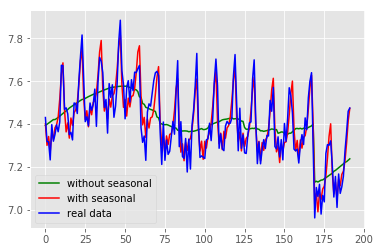

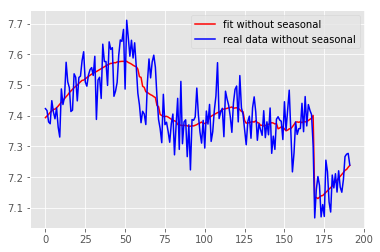

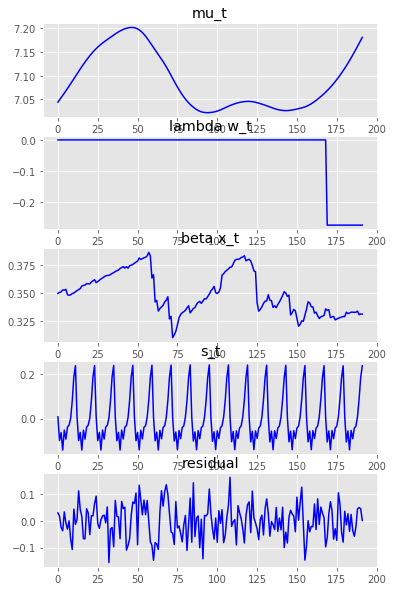

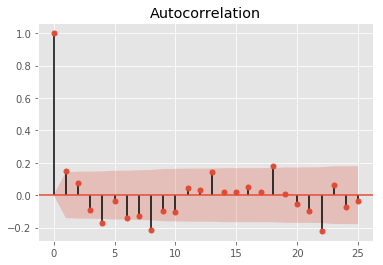

In [21]:
do_plot(calc_term_trend(fit))